# Genetic Algorithms
## Evolutionary Algorithms for Optimization

- <a href=#NGFA>Non-Gradent Following Optimization Algorithms</a>
- <a href=#GA>Genetic Algorithm</a>
- <a href=#FSML>Feature Selection for Machine Learning</a>
- <a href=#BFDS>Best-fitting Distribution Selection</a>
- <a href=#MFM>Multivariate Function Minimization</a>

<a id=top></a>

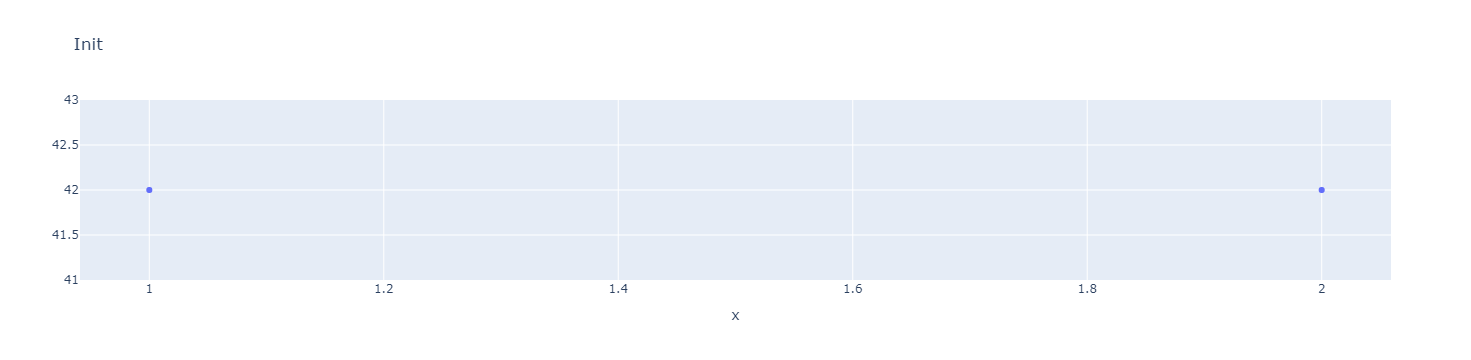

In [9]:
import numpy as np
import scipy.stats as stt
import pandas as pd
from itertools import chain

import chart_studio.plotly as ply
import chart_studio.tools as plytool
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as plyoff
import plotly.subplots as plysub

# to use plotly offline, need to initialize with a plot\n",
plyoff.init_notebook_mode(connected=True)
init = go.Figure(data=[go.Scatter({'x':[1, 2], 'y':[42, 42], 'mode':'markers'})], layout=go.Layout(title='Init', xaxis={'title':'x'}, height=100, width=100))
plyoff.iplot(init)

In [19]:
# function to print binary strings
printIndiv = lambda x: ''.join(['%d'%i for i in x])

def EncodeBinaryReal(inputType, inputValue, bits, lowerBounds, upperBounds):
    '''
    Using a specified number of bits, and lower & upper real value bounds,
    encode a list of real values as a list binary string, or a list binary
    string as a list of real values.
    :param inputType: 'r' = list of real values input; 'b' = list of
        binary values
    :param inputValue: either a list of n real values, or a single
        list of the binary representation of n real value using the
        number of bits indicated
    :param bits: n-length array_like with number of bits used to encode
        real values
    :param lowerBounds: n-length array_like with lower bound of range
        for real values
    :param upperBounds: n-length array_like with upper bound of range
        for real values
    :return outVal: if inputType is 'r', n*sum(bits)-length list of binary
        values; if inputType is 'b', n-length list of real values
    '''
    
    if inputType == 'b': # binary in, so real out
        # get the limits in the list of the individual values
        binLims = [0]+np.cumsum(bits).tolist()
        # iterate over binary strings
        outVal = [0]*len(bits)
        for indx, (low, hig, bt, lb, ub) in enumerate(zip(binLims[:-1],
            binLims[1:], bits, lowerBounds, upperBounds)):
            # get this real value's binary representation
            binV = inputValue[low:hig]
            # get the powers of 2 & max value
            exps = [2**b for b in range(bt-1,-1, -1)]
            mx = 2**bt-1
            # compute the real value
            realV = sum([b*e for (b, e) in zip(binV, exps)])
            realV = lb + (ub - lb)*realV/mx
            outVal[indx] = realV
    elif inputType == 'r': # real in, so binary out
        # iterate over real values
        reBinVal = [None]*len(inputValue)
        for indx, (realV, bt, lb, ub) in enumerate(zip(inputValue, bits, lowerBounds, upperBounds)):
            # stepsize in range
            steps = (ub - lb)/(2**bt-1)
            # values distance from lower
            dist = int((realV - lb)/steps)
            # encode the distance into binary
            binV = [int(b) for b in bin(int(dist))[2:].zfill(bt)]
            reBinVal[indx] = binV
        outVal = list(chain.from_iterable(reBinVal))
    else:
        raise TypeError('Input type may only be "b" for "r"')
    
    return outVal

## Mathematical Optimization
Optimization is the process of finding some numerical values that generate a minimum or maximum value for a specified function. Examples include finding the best parameters for a statistical distribution fit to some data, numerically solving differential equations, or feature selection / hyperparameter tuning in machine learning.

### Gradient-Following Optimization Algorithms
There are many types and classes of optimization algorithms. Most that have been invented by mathematicianas and computer scientists rely on function derivatives / gradients. These are called *gradient-following* algorithms. Anybody who's studied the topic even slightly will likely remember [Newton-Raphson](https://en.wikipedia.org/wiki/Newton%27s_method) or the [BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) - the latter of which even needs the second derivatives (the [Hessian](https://en.wikipedia.org/wiki/Hessian_matrix)). Mathematical optimization algorithms typically start with an initial test solution $x^\ast_0$, then iterate over two steps:

1. evaluate current test solution $x^\ast_i$
2. step to new test solution $x^\ast_{i+1}$

A series of individual test solutions are identified and evaluated, until the sequence converges to a final solution.

In the $2^\text{nd}$ step, gradient-followers evaluate the derivative of the function to optimize at the value $x^\ast_i$, to tell it the direction to step for $x^\ast_{i+1}$. The BFGS algorithm (and others) also uses the second derivative to tell it how far to step. Gradient-following methods can have good properties, but also two major issues:

1. The first is the need to compute derivatives. This can often be very difficult - even assuming derivatives can be analytically solved - and time consuming. Furthermore, not all functions we wish to optimize even have a derivative. What is the derivative of an accuracy loss function for a [Decision Tree Classifier](https://en.wikipedia.org/wiki/Decision_tree_learning)?

2. The second issue is that gradient-followers can easily get stuck in local optima, rather than finding a global optimum. Depending on the curvature of the function to optimize, and the value of $x^\ast_0$, the algorithm may get stuck in a local, not global, optimum.

The figure generated below demonstrates this second point. The curve to be maximized has two optima with a saddle point in between. Four possible initial solutions are shown. When the curve's gradient is evaluated at the two $x^\ast_0$ points in red, an optimization algorithm will converge to the local optimum. The two in green will converge to the global optimum. In general, any initial solution on the right side of the black vertical line will cause an optimization algorithm to converge to the global optimum; initial solutions to the left of it will converge to the local optimum.

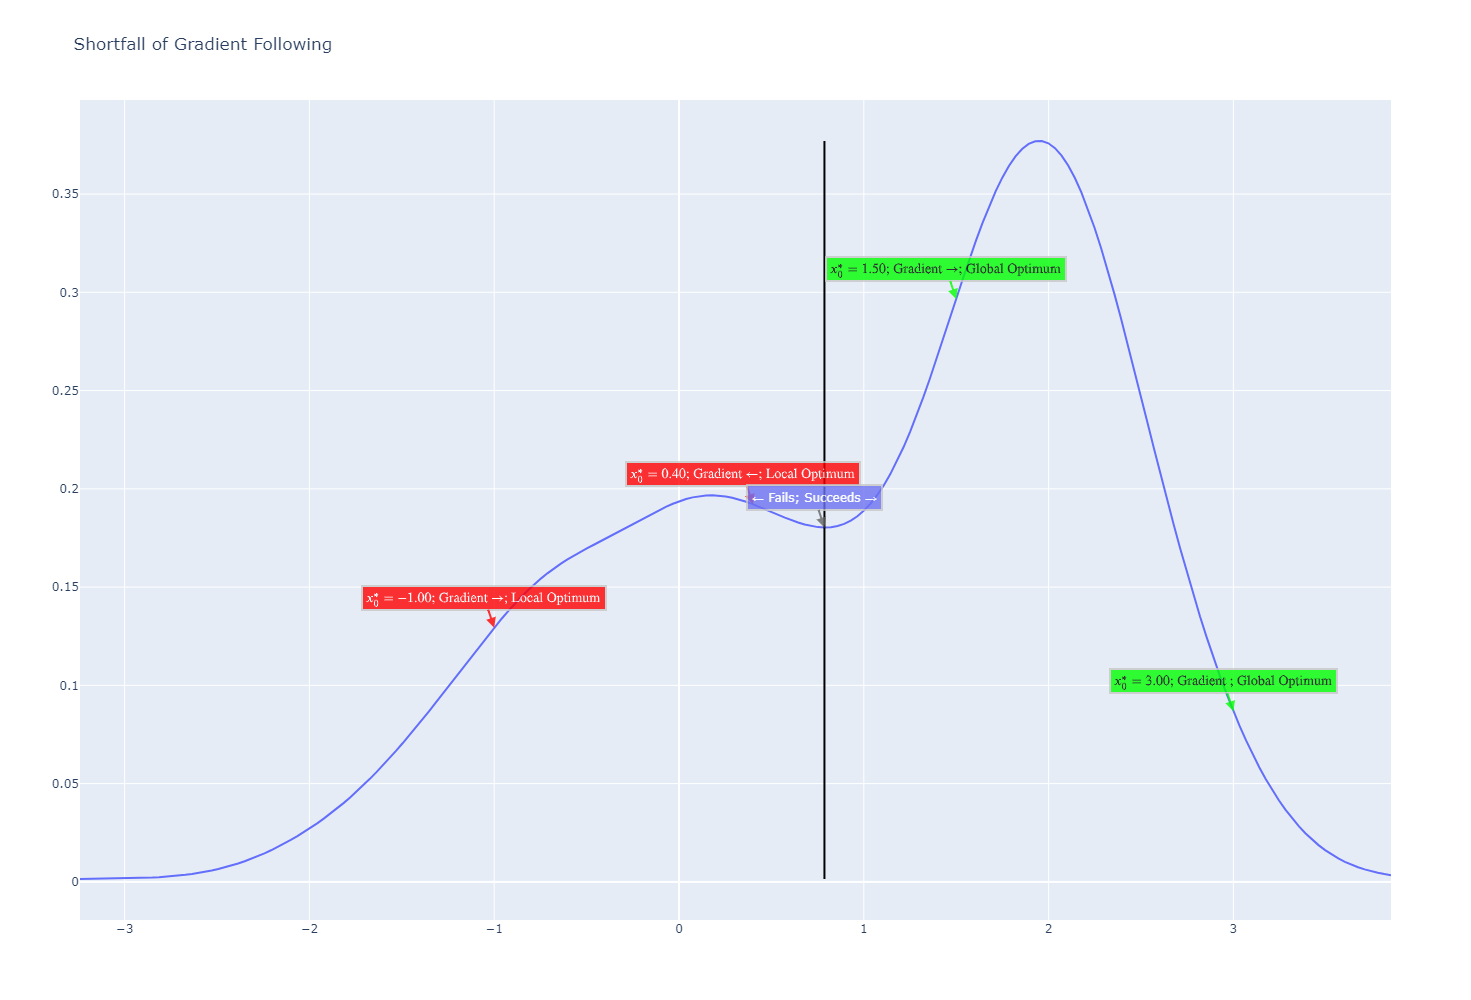

In [7]:
# get the data
np.random.seed(42)
X1 = stt.norm(loc=0, scale=1).rvs(500)
X2 = stt.norm(loc=2, scale=0.5).rvs(500)
data = np.r_[X1, X2]

# prep for kde
mn, mx = min(data), max(data)
x= np.linspace(mn, mx, 200)

# kde
kde = stt.gaussian_kde(data, bw_method=0.25)
y = kde(x)

# create the annotation
x1 = -1
y1 = kde(x1)[0]
ann1 = dict(x=x1, y=y1, xref='x1', yref='y1', text='$x^{*}_0 = %0.2f\\text{; Gradient →; Local Optimum}$'%x1, showarrow=True,
            bordercolor="#c7c7c7", borderwidth=2, borderpad=4, bgcolor="#ff0000", opacity=0.8,
            font={'color':'#ffffff'}, align="center", arrowhead=2, arrowsize=1, arrowwidth=2,
            arrowcolor="#ff0000")
x2 = 0.40
y2 = kde(x2)[0]
ann2 = dict(x=x2, y=y2, xref='x1', yref='y1', text='$x^{*}_0 = %0.2f\\text{; Gradient ←; Local Optimum}$'%x2, showarrow=True,
            bordercolor="#c7c7c7", borderwidth=2, borderpad=4, bgcolor="#ff0000", opacity=0.8,
            font={'color':'#ffffff'}, align="center", arrowhead=2, arrowsize=1, arrowwidth=2,
            arrowcolor="#ff0000")
x3 = 1.5
y3 = kde(x3)[0]
ann3 = dict(x=x3, y=y3, xref='x1', yref='y1', text='$x^{*}_0 = %0.2f\\text{; Gradient →; Global Optimum}$'%x3, showarrow=True,
            bordercolor="#c7c7c7", borderwidth=2, borderpad=4, bgcolor="#00FF00", opacity=0.8,
            font={'color':'#000000'}, align="center", arrowhead=2, arrowsize=1, arrowwidth=2,
            arrowcolor="#00FF00")
x4 = 3.0
y4 = kde(x4)[0]
ann4 = dict(x=x4, y=y4, xref='x1', yref='y1', text='$x^{*}_0 = %0.2f\\text{; Gradient ; Global Optimum}$'%x4, showarrow=True,
            bordercolor="#c7c7c7", borderwidth=2, borderpad=4, bgcolor="#00FF00", opacity=0.8,
            font={'color':'#000000'}, align="center", arrowhead=2, arrowsize=1, arrowwidth=2,
            arrowcolor="#00FF00")
x5 = 0.78698325
y5 = kde(x5)[0]
ann5 = dict(x=x5, y=y5, xref='x1', yref='y1', text='← Fails; Succeeds →', showarrow=True,
            bordercolor="#c7c7c7", borderwidth=2, borderpad=4, bgcolor="#6d72f1", opacity=0.8,
            font={'color':'#ffffff'}, align="center", arrowhead=2, arrowsize=1, arrowwidth=2,
            arrowcolor="#636363")

# plot
trcs = [go.Scatter(x=x, y=y, mode='lines', name='Kernel Density Estimate', showlegend=False),
        go.Scatter(x=[x5, x5], y=[min(y), max(y)], mode='lines', line={'color':'black'}, showlegend=False)]
fig = go.Figure(data=trcs, layout=go.Layout(title='Shortfall of Gradient Following', height=1000))
anns = list(fig['layout']['annotations'])
anns.extend([ann1, ann2, ann3, ann4, ann5])
fig.update_layout( annotations=anns)
plyoff.iplot(fig)

### Non-Gradent Following Optimization Algorithms
<a id=NGFA></a>
<a href=#top>Go to Top</a>

There are several types of mathematical optimization algorithms which similarly operate on a sequence of individual solutions, but don't use derivatives. I am familiar with [Simulated Annealing](https://en.wikipedia.org/wiki/Simulated_annealing) and [Golden Section Search](https://en.wikipedia.org/wiki/Golden-section_search) opimization.

There is an entirely different class of optimization algorithms which operate on ensembles of solutions - called a *population* - generally iteratively updating them in concert.

### Evolutionary Algorithms
The term [Evolutionary Algorithm (EA)](https://en.wikipedia.org/wiki/Evolutionary_algorithm) refers to a type of population-based metaheuristic optimization algorithm, and is a subset of [evolutionary computation](https://en.wikipedia.org/wiki/Evolutionary_computation). Broadly, evolutionary algorithms are designed around concepts which come from biological evolution (duhh!). There are several classes of evolutionary algorithms:

- Differential Evolution
- Evolutionary Programming
- Evolutionary Strategy
- Genetic Algorithm
- Genetic Programming ([see here](https://github.com/ahowe42/baseball))
- Learning Classifier System
- Neuroevolution

This set of lectures is focused on the Genetic Algorithm (GA), but could potentially be extended to include [Genetic Programming](https://en.wikipedia.org/wiki/Genetic_programming).

### Other Gradient Eschewing Algorithms
In addition to EA's, there are several other types of metaheuristic optimization algorithms that are based on the idea of optimizing with a population of potential solutions. These include:

- [Ant Colony Optimization - or Traveling Ant Colony Optimization (TACO)](https://en.wikipedia.org/wiki/Ant_colony_optimization_algorithms)
- [Particle Swarm Optimization](https://en.wikipedia.org/wiki/Particle_swarm_optimization)
- [Bees Algorithm](https://en.wikipedia.org/wiki/Bees_algorithm)
- [Adaptive Dimensional Search](https://en.wikipedia.org/wiki/Adaptive_dimensional_search)
- [Gaussian Adaptation](https://en.wikipedia.org/wiki/Gaussian_adaptation)
- Harmony Search - special case of [Evolution Strategy](https://en.wikipedia.org/wiki/Evolution_strategy)

I am only familiar with a few of these.

## Genetic Algorithm
<a id=GA></a>
<a href=#top>Go to Top</a>

The genetic algorithm (GA) is a stochastic population-based metaheuristic optimization algorithm that borrows concepts from biological evolution. In the GA, a solution to an optimization problem is represented as a binary word of length $n$. In the GA parlance, this is metaphorically called an *individual*, or *chromosome*. Each solution is part of an ensemble of solutions which are considered together; this is called the *population*. The function to be optimized is called the *objective function*, or the *fitness function* - the latter is a metaphor to the biological concept of "survival of the fittest".

The semantic meaning of the binary word as a solution that optimizes an objective function (an individual being the most fit in it's environment) depends on the context. The binary word could represent selection flags for a feature selection problem; if instead the GA is being used to optimize a real-valued function, the word could be a digital representation of possible real values. In [this research article](https://www.researchgate.net/publication/301770005_Regularized_SVM_Classification_with_a_new_Complexity-Driven_Stochastic_Optimizer), I used the GA to simultaneously select a subset of features and one of 9 kernel functions for [kernel SVM classification](https://en.wikipedia.org/wiki/Support-vector_machine). The same binary word had one portion interpreted as binary flags, and the other portion as digital representations of the integers 1 to 9.

### Feature Selection
If a dataset has $p$ features, each GA individual is a p-length binary word indicating that a feature is in that solution (1) or out of it (0). If $p=8$, for example, one solution may be $11011001$; in this case, features 1,2,4,5,8 will be used, while 3,6,7 will not.

### Real-Valued Function Optimization
To decode an $n$-length binary word $B$ into a real value $R$, the lower $L$ and upper $U$ bounds of the possible values must be provided. $R$ is then decoded from $B$ using the following steps:
\begin{align}
pow =& [2^j]\text{ for }j=0,1,\ldots,n-1\\
stepsize =& \sum_{j=0}^{n-1} pow_{j}\times B_{j}\\
R =& L + \left(U-L\right)\frac{steps}{2^n-1}
\end{align}
In the first step, $j$ iterates from the right to left, such that $pow$ is an $n$-length vector of integer powers of two. For example, if $B=10101$, we get
\begin{align}
pow =& [2^4=16, 2^3=8, 2^2=4, 2^1=2, 2^0=1]\\
stepsize =& \sum[1\times2^4 + 0\times2^3 + 1\times2^2 + 0\times2^1 + 1\times2^0] = 21
\end{align}

To instead encode $R$ into a binary word $B$, we compute:
\begin{align}
stepsize =& \frac{U - L}{2^n-1}\\
dist = & \frac{R - L}{stepsize}
\end{align}
The value $dist$ is then cast to an integer and encoded using the computer's binary representation.

It should be clear from these calculations that the granularity and precision of encoded solutions is controlled by the
- range of possible values
- number of bits

To obtain more precise solutions from the GA, use a narrower range of possible values and / or more bits. Only the second, however, inflates the solution space. The next cell demonstrates encoding real values, varying the $U-L$ ranges and number of bits $n$.

In [20]:
''' Real <-> Binary Encoding '''
# setup real values to be binary encoded, demonstrating the effect of different range widths & different
reals =  [42, 42, 42, 0, 100, 0, 100]
lowers = [10, 30, 30, 0, 0, 0, 0]
uppers = [74, 54, 54, 100, 100, 100, 100]
bits =   [8, 8, 16, 8, 8, 16, 16]

# encode & then decode
B = EncodeBinaryReal('r', reals, bits, lowers, uppers)
R = EncodeBinaryReal('b', B, bits, lowers, uppers)

# parse B
cumBits = np.cumsum([0]+bits)
B = [printIndiv(B[f:t]) for (f, t) in zip(cumBits[:-1], cumBits[1:])]

# compute R->B steps to show granularity
steps = [(u-l)/(2**b-1)for (u, l, b) in zip(uppers, lowers, bits)]

# show all in a dataframe
df = pd.DataFrame(data=np.c_[[reals, lowers, uppers, bits, B, steps, R]], index=['Input Real', 'Lower Bound', 'Upper Bound', 'Bits', 'Binary', 'Step Size', 'Output Real'])
display(df)

,0,1,2,3,4,5,6
Input Real,42,42,42,0,100,0,100
Lower Bound,10,30,30,0,0,0,0
Upper Bound,74,54,54,100,100,100,100
Bits,8,8,16,8,8,16,16
Binary,01111111,01111111,0111111111111111,00000000,11111111,0000000000000000,1111111111111111
Step Size,0.25098039215686274,0.09411764705882353,0.0003662165255207141,0.39215686274509803,0.39215686274509803,0.0015259021896696422,0.0015259021896696422
Output Real,41.87450980392157,41.95294117647059,41.99981689173724,0.0,100.0,0.0,100.0


The objective function is usually a map, $\phi\left(X\in\mathcal{R}^{m\times p}, I^n\right) \rightarrow \mathcal{R}$, jointly mapping some data plus a binary word to a scalar real value. GAs have also been developed for multi-objective optimization, in which case the objective function would map to a real-valued vector of length $q$: $\phi\left(X\in\mathcal{R}^{m\times p}, I^n\right) \rightarrow \mathcal{R}^q$. There are several approaches to this - I find approaches that use a [Pareto Front](https://en.wikipedia.org/wiki/Pareto_front) quite appealing.

All optimization algorithms need to start with an initial solution, and the same is true for the GA. For the GA, there may be domain knowledge-based ways to generate an initial population of $P$ individuals. However, it is common to initialize the population randomly, such that each bit has a 50% chance of being turned on. Starting from the initial population, the GA iterates over a few steps:

1. score the fitness of each individual in the population
2. rank and select individuals for mating
3. mate pairs of individuals to create a new population

    a. crossover
    
    b. mutation
    
    c. GA engineering
4. apply any other GA operators

Each population of individuals is called a *generation*. There are several ways to rank and select individuals for mating. There are also several operators that can be used in the GA, mostly related to creating a new generation. The following cells will explain and demonstrate these steps.

In [21]:
''' generate a sample population with scores '''
# generate the population and scores
n = 10
P = 8
np.random.seed(1906)
population = np.random.rand(P, n) > 0.5
fitness = np.random.rand(P)

# sort
stdIndex = np.argsort(fitness)[::-1]
population = population[stdIndex]
fitness = fitness[stdIndex]

# talk
print('Sample population with %d %d-length individuals'%(P,n))
for indx, (score, individual) in enumerate(zip(fitness, population)):
    print('%d: %s = %0.3f'%(indx, printIndiv(individual), score))

Sample population with 8 10-length individuals
0: 1001010001 = 0.889
1: 1000100000 = 0.683
2: 0111101011 = 0.537
3: 0110111110 = 0.448
4: 0101111001 = 0.423
5: 1111011110 = 0.259
6: 1111111110 = 0.156
7: 0001011111 = 0.127


### Mating Ranking & Selection
In the GA, mating is the process of combining two individuals to generate new individuals. I generally have two *parent* solutions mate to create a pair of *child* solutions. I do this is to keep a constant population size, but it's not required. For example, mating could choose to create, based on a randomized choice either:

- a single offspring + new random individual
- a pair of offspring

The new random individual in the first option could be thought of as *adoption*, and would help explore the solution space. I generally use an even number for population size, as it simplifies this step. If the GA is being run to optimize multiple objectives, this is the part of the algorithm that is most affected, as fitness scores are predominantly used to determine which individuals mate. I have generally used two approaches to mating ranking & selection - both of the below are more complicated for multi-objective problems.

#### Sorted
In biology, it is often the case that individuals that are similarly fit for their environment mate together (hence, the phrase "she's out of my league"). The metaphor generally holds for the GA, in that solutions with similar objective function scores are mated. This doesn't have to be the case. For example, we could mate pairs of solutions best-fitness to worst-fitness. This approach may help better explore the solution space, but I've never used it. 

The sorted approach to mate ranking and selection is simple, and has the property that each individual mates exactly and only one time. For this, all individuals are sorted according to their fitness scores, then paired off in sequence, so there are $P/2$ mating pairs generated.

In [22]:
''' pair individuals for mating - sorted method '''
# skipping sorting, as the population is already sorted
pairs = np.reshape(range(P), (P//2, 2))
# talk
for (indx, pair) in enumerate(pairs):
    print('Mating pair %d: %s (%0.3f) <-> %s (%0.3f)'%(indx, printIndiv(population[pair[0]]), fitness[pair[0]],
                                                       printIndiv(population[pair[1]]), fitness[pair[1]]))

Mating pair 0: 1001010001 (0.889) <-> 1000100000 (0.683)
Mating pair 1: 0111101011 (0.537) <-> 0110111110 (0.448)
Mating pair 2: 0101111001 (0.423) <-> 1111011110 (0.259)
Mating pair 3: 1111111110 (0.156) <-> 0001011111 (0.127)


#### Roulette
In biology, it is often the case that the most fit individuals mate the most, thus propagating their successful genes. This metaphor holds by design with the roulette method for generating mating pairs.

The roulette method starts by sorting all individuals according to their fitness scores, then generating a biased roulette bar, in which the individual bins are of gradually decreasing width. The width of the $i^\text{th}$ bin $b_i$ is computed using the formula:
\begin{equation}
b_i = \frac{2j}{n\left(n+1\right)}\text{, for }i=,1,2,\ldots,P\text{ and }j=P, P-1,\ldots,1\text{.}
\end{equation}
When the cumulative sum of these bin widths is computed, we get upper bounds for the roulette bins, which completely partition the $[0, 1]$ interval. Each bin corresponds to an individual in the population; since the population was already sorted by fitness score, the wider bins correspond to the most fit individuals. For $P=4$, this is computed and visualized as:

<center><img src='../images/roulette_selection.png' width='400' height='200'></center>

Since we don't want the population to grow, we will generate $P/2$ mating pairs. To do so, $P$ random numbers are generated uniformly from $[0, 1]$ (written as $U\left(0, 1\right)$) and placed in the appropriate bin. For each random variate in the $i^\text{th}$ bin, the corresponding individual will be selected to mate. In this way, individuals with a better fitness score are overrepresented in the mating pool. The last step is to randomly permute the ordering of the individuals in the mating pool.

Note that this means that, while the most fit individuals will tend to mate the most frequently, they won't just mate with individuals with similar fitness scores.

In [27]:
''' pair individuals for mating - roulette method '''
# generate the bounds and show the bins
binUBounds = np.cumsum(2*np.linspace(P, 1, P)/(P*(P + 1.0)))
bnds = [0] + binUBounds.tolist()
print('Roulette bins: %r'%[('%0.2f'%f, '%0.2f'%t) for f, t in zip(bnds[:-1], bnds[1:])])

# generate mating frequencies
np.random.seed(2022)
rands_in_bins = np.repeat(np.random.rand(P), P) >= np.tile(binUBounds, P)
pairs = np.reshape(np.random.permutation(np.sum(np.reshape(rands_in_bins, [P]*2), axis=1)), (P//2, 2))

# talk
for (indx, pair) in enumerate(pairs):
    print('Mating pair %d: %s (%0.3f) <-> %s (%0.3f)'%(indx, printIndiv(population[pair[0]]), fitness[pair[0]],
                                                       printIndiv(population[pair[1]]), fitness[pair[1]]))

Roulette bins: [('0.00', '0.22'), ('0.22', '0.42'), ('0.42', '0.58'), ('0.58', '0.72'), ('0.72', '0.83'), ('0.83', '0.92'), ('0.92', '0.97'), ('0.97', '1.00')]
Mating pair 0: 0111101011 (0.537) <-> 0110111110 (0.448)
Mating pair 1: 1001010001 (0.889) <-> 0111101011 (0.537)
Mating pair 2: 1111011110 (0.259) <-> 1001010001 (0.889)
Mating pair 3: 0110111110 (0.448) <-> 1001010001 (0.889)


### Crossover
In biology, when a pair of individuals mate, their chromosomes are combined in a process called [chromosomal crossover](https://en.wikipedia.org/wiki/Chromosomal_crossover). An illustration from 1916 by researcher Thomus Hunt Morgan demonstrates the creation of recombinant genes through this process.

<img src='https://upload.wikimedia.org/wikipedia/commons/0/0e/Morgan_crossover_1.jpg' height='500' width='500'>

In the GA, after mating pairs are generated from a population, whether or not the crossover operation is employed is controlled by the crossover probability $P_X$. If a random variate generated from $U\left(0, 1\right)$ is less than $P_X$, crossover is used. Otherwise, a mating pair produces a pair of offspring that are genetic replicants. Since crossover increases exploration of the objective function's solution space, I generally use a high probability - at least $P_X = 0.7$. I use three types of crossover.

#### Single-Point
In single-point crossover, a single crossover point (see what I did there?) is identified by generating an integer from $U\left(1, n\right)$ randomly. The two individuals in a mating pair have their chromosomes traded at that bit, as shown in the illustration above.

In [28]:
''' single-point crossover '''
# generate the crossover flags
np.random.seed(42)
probXover = 0.7
xovers = np.random.rand(len(pairs)) < probXover

# crossover
newPop = [None]*(2*len(pairs))
for (indx, pair) in enumerate(pairs):
    # get the individuals
    p1 = population[pair[0]]
    p2 = population[pair[1]]
    if xovers[indx]:
        # genetic replication
        xoverpoint = 0
        n1, n2 = p1, p2
        newPop[indx*2] = n1
        newPop[indx*2+1] = n2
    else:
        # crossover
        xoverpoint = np.random.randint(1, n-1)
        n1 = np.concatenate((p1[:xoverpoint], p2[xoverpoint:]))
        n2 = np.concatenate((p2[:xoverpoint], p1[xoverpoint:]))
        newPop[indx*2] = n1
        newPop[indx*2+1] = n2
    # talk
    print('Mating pair %d (xover=%d): %s <-> %s --> %s & %s'%(indx, xoverpoint, printIndiv(p1), printIndiv(p2), printIndiv(n1), printIndiv(n2)))
newPop = np.array(newPop)

Mating pair 0 (xover=0): 0111101011 <-> 0110111110 --> 0111101011 & 0110111110
Mating pair 1 (xover=7): 1001010001 <-> 0111101011 --> 1001010011 & 0111101001
Mating pair 2 (xover=2): 1111011110 <-> 1001010001 --> 1101010001 & 1011011110
Mating pair 3 (xover=0): 0110111110 <-> 1001010001 --> 0110111110 & 1001010001


#### Dual-Point
Dual-point crossover works similarly, except two crossover points are generated randomly in the same way as single-point crossover. The chromosomes are partitioned and traded at these bits. This is shown in the illustration below, also from Thomas Hunt Morgan.

<img src='https://upload.wikimedia.org/wikipedia/commons/4/45/Morgan_crossover_2.jpg' width='500' height='500'>

In [29]:
''' dual-point crossover '''
# generate the crossover flags
np.random.seed(42)
probXover = 0.7
xovers = np.random.rand(len(pairs)) < probXover

# crossover
newPop = [None]*(2*len(pairs))
for (indx, pair) in enumerate(pairs):
    # get the individuals
    p1 = population[pair[0]]
    p2 = population[pair[1]]
    if xovers[indx]:
        # genetic replication
        xoverpoints = [0,0]
        n1, n2 = p1, p2
        newPop[indx*2] = n1
        newPop[indx*2+1] = n2
    else:
        # crossover
        xoverpoints = np.sort(np.random.permutation(n-1)[:2]+1)
        n1 = np.concatenate((p1[:xoverpoints[0]], p2[xoverpoints[0]:xoverpoints[1]], p1[xoverpoints[1]:]))
        n2 = np.concatenate((p2[:xoverpoints[0]], p1[xoverpoints[0]:xoverpoints[1]], p2[xoverpoints[1]:]))
        newPop[indx*2] = n1
        newPop[indx*2+1] = n2
    # talk
    print('Mating pair %d (xover=[%d, %d]): %s <-> %s --> %s & %s'%(indx, xoverpoints[0], xoverpoints[1], printIndiv(p1), printIndiv(p2), printIndiv(n1), printIndiv(n2)))
newPop = np.array(newPop)

Mating pair 0 (xover=[0, 0]): 0111101011 <-> 0110111110 --> 0111101011 & 0110111110
Mating pair 1 (xover=[5, 8]): 1001010001 <-> 0111101011 --> 1001001001 & 0111110011
Mating pair 2 (xover=[1, 7]): 1111011110 <-> 1001010001 --> 1001010110 & 1111011001
Mating pair 3 (xover=[0, 0]): 0110111110 <-> 1001010001 --> 0110111110 & 1001010001


#### Uniform
Uniform crossover is the logical endpoint of the sequence of types of crossovers shown here. With uniform crossover, a random variate is generated from $U\left(0, 1\right)$ for each of the $n$ bits in the chromosomes being crossed over. For each bit such that the random value is less than $P_X$, that bit of the binary word is traded between the two individuals in the mating pair.

In [30]:
''' uniform-point crossover '''
# generate the crossover flags
np.random.seed(1211)
probXover = 0.7
xovers = np.random.rand(len(pairs)) < probXover

# crossover
newPop = [None]*(2*len(pairs))
for (indx, pair) in enumerate(pairs):
    # get the individuals
    p1 = population[pair[0]]
    p2 = population[pair[1]]
    if xovers[indx]:
        # genetic replication
        xoverpoint = [0]*n
        n1, n2 = p1, p2
        newPop[indx*2] = n1
        newPop[indx*2+1] = n2
    else:
        # crossover
        xoverpoints = probXover > np.random.rand(n)
        n1 = p1*xoverpoints + p2*~xoverpoints
        n2 = p1*~xoverpoints + p2*xoverpoints
        newPop[indx*2] = n1
        newPop[indx*2+1] = n2
    # talk
    print('Mating pair %d (xover=%s): %s <-> %s --> %s & %s'%(indx, printIndiv(xoverpoints), printIndiv(p1), printIndiv(p2), printIndiv(n1), printIndiv(n2)))
newPop = np.array(newPop)

Mating pair 0 (xover=1101100101): 0111101011 <-> 0110111110 --> 0111111011 & 0110101110
Mating pair 1 (xover=0011110010): 1001010001 <-> 0111101011 --> 0101011001 & 1011100011
Mating pair 2 (xover=0011110010): 1111011110 <-> 1001010001 --> 1111011110 & 1001010001
Mating pair 3 (xover=1011011011): 0110111110 <-> 1001010001 --> 0010011010 & 1101110101


### Mutation
After mating pairs use crossover to generate a new population of individuals, the new individuals' chromosomes are mutated. Mutation simply entails flipping bits in the chromosome randomly, according to a small mutation probability $P_M$. To mutate an individual, $n$ random variates are generated from $U\left(0, 1\right)$. For any that are less than $P_M$, the corresponding bits are flipped. I generally use a low probability, such as $P_M=0.10$. Mutation helps the GA explore the solution space; even if the population tends to become more homogenous in later generations, mutation helps ensure heterogeniety.

In [ ]:
''' mutation '''
# generate mutation flags
probMutate = 0.1
mutators = probMutate > np.random.rand(P, n)
dat = pd.DataFrame(data = [printIndiv(m) for m in mutators], columns=['Mutate Flags'])

# mutate
dat['Before'] = [printIndiv(n) for n in newPop]
newPop = newPop.copy()
newPop[mutators] = ~(newPop[mutators])
dat['After'] = [printIndiv(n) for n in newPop]

# talk
display(dat)

### GA Engineering
One criticism of the GA is that, due to its stochastic nature, subsequent replications of the GA can end up with very different solutions to the same problem. This typically only occurs if a problem is very large and / or when the number of generations and population size are set too low. One solution is to employ an operator called *GA engineering*, which is intended to reduce variability between replications. Continuing the metaphor, GA engineering is akin to genetic engineering, in which genes from a more successful individual - such as a plant that is pest-resistant - is inserted into other individuals.

GA engineering is employed after a new population has been created, when the best solution from the previous generation is better than the best solution of the current generation. The process takes the best individual from the previous and current generations, and finds the differences in their chromosomes; we'll call $\Delta_{P-C}$ the bits that are on in the previous but not current best chromosome. $P$ random values are then generated from $U\left(0, 1\right)$; for individuals in the new population corresponding with a random variate being less than the probability of engineering $P_E$, the bits in $\Delta_{P-C}$ are inserted. I usually set $P_M > P_E > P_X$.

In [ ]:
''' GA engineering '''
engineer_rate = 0.2
# make a previous best
prevBest = np.array([True, True, False,  True, True,  False, False, False, True, True])
# get the difference
currBest = population[np.argmax(fitness),:]
diffLocs = np.logical_xor(currBest, prevBest)
diffVals = prevBest[diffLocs]

# print bests
print('Previous Best: %s'%printIndiv(prevBest))
print(' Current Best: %s'%printIndiv(currBest))

# coin flips for implementing
np.random.seed(42)
engme = engineer_rate > np.random.rand(P)

# engineer
dat = pd.DataFrame({'Engineer':engme, 'Before':[printIndiv(m) for m in newPop]})
newPopC = np.zeros((P, n), dtype=bool)
rows = np.arange(P)
# first build the output by adding the population elements that won't be changed
rows_nochg = rows[~engme]
newPopC[rows_nochg, :] = newPop[~engme, :]
# now edit the rest of the population
jnk = newPop[engme, :]
jnk[:, diffLocs] = diffVals
newPopC[rows[engme], :] = jnk
newPop = newPopC
dat['After'] = [printIndiv(m) for m in newPop]

# talk
display(dat)

### Elitism
In the GA, individuals in a generation generally die after mating, leaving the next generation all offspring. In real life, it can occasionally happen that an especially fit individual will remain a desirable mating partner for more than one generation; think Sean Connery, Harrison Ford, or Charlton Heston. This cross-generation interaction can be implemented as an option in the GA, with the *elitism* rule. When elitism is on the most fit solution from the current generation does not die, but joins the mating pool in the next generation. If there is already an individual in the next generation with the same chromosome, this has no effect.

An advantage of elitism is that every generation always has the best individual in the population, so the GA's performance is monotonic. However, elitism means the population may grow with each generation. This can complicate mate ranking & selection, but is easily handled. Alternatively, we could design the GA to drop a random individual from the population before inserting the best individual, but this would hinder exploration of the solution space.

Since elitism means that the best solution ever found by the GA is always in the mating pool, GA engineering is of limited value. I don't use both together.

In [ ]:
''' elitism '''
varis = np.arange(n) + 1
bin_to_dec = 2**(varis - 1)
    
# check if best is currently in new_pop
tmp1 = np.sum(newPop*bin_to_dec, axis=1)
tmp2 = np.sum(currBest*bin_to_dec)

if tmp2 not in tmp1:
    population = np.vstack((newPop, currBest))
    print('Elitism applied')
    for (indx, individual) in enumerate(population):
        print('%d: %s'%(indx, printIndiv(individual)))
else:
    population = newPop.copy()
    print('Elitism not necessary')

These steps are iterated over a specified number of generations.

While the GA is not guaranteed to find the global optima, with appropriately-set parameters, it will most likely get very close. Indeed, the [no free lunch theorem](https://en.wikipedia.org/wiki/No_free_lunch_theorem) tells us that no optimization algorithm can outperform all others on all problems. Wolpert and Macready, who introduced the theorem stated "*We have dubbed the associated results NFL theorems because they demonstrate that if an algorithm performs well on a certain class of problems then it necessarily pays for that with degraded performance on the set of all remaining problems.*".

Optimization problems have two jobs:
- exploration: As compared to gradient-followers, or other otimization algorithms which consider solutions individually, population-based algorithms do a much better job of exploring the solution space. In the GA specifically, operators which can generate novel solutions such as mutation and crossover, help explore the solution space. A best solution which is near a local optimum may be a single bit's mutation away from the global optimum.

- exploitation: The second job of an optimization algorithm is to more carefully explore promising areas of the solution space. This is something some gradient-following algorithms do well *when they are near the global optimum*. The BFGS algorithm is one. In the GA, GA engineering and the elitism rule help exploit good solutions, as they ensure useful elements of good chromosomes are not lost through mutation or crossover.

In some cases, it may be beneficial for the GA to explore more in early generations, and exploit more in later generations. This could be implemented by setting a higher initial mutation rate, then allow the crossover and mutation probabilities to decay by generation. This is similar to the adaptive learning rate used by many optimizers for training deep learning neural networks. In simulated annealing, a decaying temperature parameter allows the algorithm to explore the solution space more thoroughly in earlier iterations. When the temperature is hot, the algorithm has a probability to make a move to a "worse" solution. As the temperture cools, the probability of a bad move approaches 0.

### Other GA Parameters
There are various other parameters that I often add to how the genetic algorithm runs.

#### Initial Percentage
As stated earlier, it is common to initialize the population randomly, such that each bit has a 50% chance of being turned on, but this isn't necessary. I often specify an *initial percentage* parameter, which specifies what percentage of all bits in the initial population should be flipped on.

#### Premature Termination
If the GA has settled on a solution which doesn't get improved over many generations, there may be no value to continuing the algorithm - especially if compututation is expensive. To handle this, the GA can accept additional parameters

- *no change terminate* - number of generations $T$
- *convergence criteria* - minimal change between generations $\Delta_\min$

If $T$ generations pass with $\Delta\left(\text{generation_best_score} - \text{best_score}\right) <= \Delta_\min$, the algorithm terminates prematurely.

#### Seed Solutions
In addition to randomly initializing the population, there can sometimes be value in including specific solutions - *seed solutions* - in the initial population. This would usually be used to add some domain knowledge into how the GA runs. I have only ever used it when the GA is used for feature selection. For example, it could be useful for the initial population to start with solutions encoding only singleton feature subsets.

#### Replications
We call each time we run the genetic algorithm for a specific problem a *replication*. Because of how it explores the solution space, the GA will generally converge to a near-global solution. However, it is a stochastic search algorithm, so it is possible that different replications may result in different solutions, depending on the parameters. Besides using better parameters - which may not always be the cause of this variability, or even possible - we can run multiple replications, and take the best of the best solutions among all replications as the final best solution. A good use of seeding solutions is to have the best solution from a replication seeded into the initial population of the next replication. The feature selection for machine learning notebook does this.

# Genetic Algorithm Applied
I demonstrate use of the GA on three problems:

- Feature Selection for Machine Learning
- Best-fitting Distribution Selection
- Multivariate Function Minimization

## Feature Selection for Machine Learning

<a id=FSML></a>
<a href=#top>Go to Top</a>

Statistical modelers have been trying models on subsets of features for almost as long as statistical modeling (most of what we call "machine learning" is actually statistical modeling) has been around. Perhaps unimaginably, we call the process of selecting a subset of available features [feature selection](https://en.wikipedia.org/wiki/Feature_selection). In feature selection, we use some procedure to generate subsets of the existing features, fit a model to them, and evaluate that model to find an optimal subset. The goal of feature selection is usually to balance two considerations: model performance and model complexity. It is generally beneficial for a model to be simpler - to use fewer features, for example. Practitioners often prefer a simpler model, even if it performs slightly worse than a more complex model. This follows the principle of [Occam's Razor](https://en.wikipedia.org/wiki/Occam%27s_razor).

A simple way to perform feature selection, that guarantees finding the most optimal subset of features, is combinatorial enumeration - a.k.a. brute force. Combinatorial enumeration does exactly what it sounds like - the model is evauated on the enumeration of all possible combinations of features. This is no mean feat, as the number of ways to combine $p$ features is exponential in $p$; there are $2^{p-1}$ possible subsets.

The [GA Feature Selection Notebook](./GA_FeatureSelection.ipynb) demonstrates feature selection with the GA for a given dataset with the goal of minimzing error from a machine learning model. The data is simulated using a known dependence structure, so it is possible to assess the accuracy of the GA result.

I begin by simulating $n=100$ observations of $p=20$ independent features, with each value drawn randomly from $U\left(0, \gamma=5\right)$, so $X\in\mathcal{R}^{n\times p}$. A target variable $y$ is then generated as
\begin{equation}
y = 8X_0 - X_1 + 4X_2
\end{equation}
Most of the features are uncorrelated with the target and each other, as shown in the [Feature Correlations Plot](https://github.com/ahowe42/FeatureCorrelationsPlot):

<center><img src='../images/Correlations_8X0__1X1_4X2.png' height='1600'></center>

With $p=20$ features, there are a total of $2^{20}-1=1,048,575$ possible subset regression models which can be fit to these features. 

The GA was run with the inputs shown below, terminating early after around 90 generations, and evaluating only $25,828$ subsets of features - 2.5% of the total possible.

<center><img src='../images/GAProgress_20220131161948_8X0__1X1_4X2_RegressionMetric.png' height='2000'></center>

The top pane of the progress plot shows that the GA found the final solution in the 11$^{\text{th}}$ generation - the solution includes the three correct features + only one additional feature. The annotation on the plot indicates the solution binary word, number features included, subset fitness score, and the score relative to the score of the saturated model (all features included). The bottom pane plots the average fitness score of all solutions per generation. Note that, even while the best solution was found in an early generation, the GA was still exploring the solution space quite well, as the average scores remained quite high relative to the best score, oscillating around 6.25 or so.

Finally, I generated four typical regression diagnostic plots based on the model residuals (from top left, clockwise):

- target vs. predictions scatter plot - to assess how well the predictions match
- histogram of residuals - to assess if the residuals appear to be Gaussian white noise centered on $0$
- residuals ordered by data - to assess if there are any sequence-dependent patterns
- residuals by target - to assess if the level of residuals shows a pattern vis-a-vis the level of target values

<center><img src='../images/GAPerformance_20220131162231_8X0__1X1_4X2_RegressionMetric_metric__RMSE___estim_LinearRegression_fit_intercept_False___optimGoal__1.png' height='2000'></center>

The plots show that the predicted values match the targets quite well, with very small errors that have no perceivable pattern.

In conclusion, the GA did a good job of finding very close to the true [data generating process](https://en.wikipedia.org/wiki/Data_generating_process), settling on a set of features that included only a single extraneous feature. This performance is very satisfying, but recall that the data was generated with no additional noise. Adding noise would have changed the outcome, but this is likely an artifact of the simulation protocol, in that every feature was essentially white noise. This demonstration used a linear regression model, but other machine learning models could have been passed to the objective function. In fact, something completely different could have been used for the objective function. One good possibility could be some function of the mutual information among pairs of included features and the target variable. Finally, note that feature selection is particularly amenable to multi-objective optimization, in that we'd like to simultaneous find the best-fitting model, while penalizing for too much complexity. In this case, complexity could simply be measured by how many features are included, or perhaps something even more (wait for it) complex.

## Best-fitting Distribution Selection

<a id=BFDS></a>
<a href=#top>Go to Top</a>

There are three major perceptions of data in statistics:
- [Frequentist](https://en.wikipedia.org/wiki/Frequentist_inference) - considers observed data to be a random sample from an unknown population generated by a "real" probability distribution
- [Bayesian](https://en.wikipedia.org/wiki/Bayesian_inference) - considers observed data to be "real", which can be represented by a probability distribution
- [Information Theoretic](https://en.wikipedia.org/wiki/Information_theory) - focuses on determining the maximal amount of information in (or that can be gleaned from) some data

The Frequentist perspective underlies the majority of statistical thinking used, and gives us hypothesis testing and confidence intervals. An exercise commonly performed in statistics - whether Frequentist of Bayesian - is that of determining a statistical probability distribution $f\left(X\vert\theta\right)$ which fits a dataset $X$ best, given a vector of parameters $\theta$ (the length of which depends on $f$). Frequentists will pick the distribution and it's parameters by maximizing the likelihood function $l\left(\theta\vert X\right)$, or the log likelihood $\log l\left(\theta\vert X\right)$ instead:
\begin{align}
l\left(\theta\vert X\right) =& \prod_i^{n}f\left(X\vert\theta\right)\\
\log l\left(\theta\vert X\right) =& \sum_i^{n}\log\big(f\left(X\vert\theta\right)\big)
\end{align}
Note that the log likelihood is the sum of the log of the probability densities for each observed datapoint, given parameters $\theta$. The [maximum likelihood estimate](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation), or MLE $\hat{\theta}$, is the parameter vector which has the highest probability of generating the sample data observed. Instead of finding the parameters which maximize the log likelihood, Bayesians will use the [highest posterior density interval (or credibility interval)](https://en.wikipedia.org/wiki/Credible_interval). MLE's for some statistical distributions, such as the Gaussian, can be found analytically, computed as a function of the observed sample data. For example, the univariate Gaussian distribution and the MLE's of it's parameters $\mu$ and $\sigma$ are:
\begin{align}
f\left(x_i\vert\mu,\sigma\right) =& \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x_i-\mu}{\sigma}\right)^2}\\
\hat{\mu} =& \bar{X} = \frac{1}{n}\sum_{i=1}^n x_i\\
\hat{\sigma} = & S = \frac{1}{n-1}\sum_{i=1}^n \left(x_i-\bar{X}\right)^2
\end{align}

For most other probability distributions, the likelihood function must be numerically optimized. If the MLE for a distribution $f$ fit to a dataset $X$ gives the parameters most likely to have generated the observed sample data, then we can pick the distribution $\hat{f}$ most likely to have generated the sample data by as the distribution associated with the maximum likelihood evaluated at the MLE's:
\begin{equation}
\hat{f} = \underset{j}{argmax}\big[\log l_j\left(\hat{\theta}_j\vert X\right)\big]\text{, for }\big[j\in\text{set of distributions}\big].
\end{equation}

To use the GA to find the MLE's for a distribution with $n$ parameters, each binary word on which the GA operates should be of length $\sum_{i=1}^nq_i$, with the $i^\text{th}$ parameter being encoded in $q_i$ bits. There is no requirement for $q_i = q_j$.

The [GA Real Optimization - Statistical Distribution Fitting](./GA_RealOptimization_DistFit.ipynb) demonstrates using the GA to find the best fitting distribution for a given dataset. The data is simulated from a distribution with known parameters, so it is possible to assess the accuracy of the GA result.

While the notebook allows the sample data to be generated from any of the distributions below - plus the lognormal and uniform - I begin by generating $n=100$ random observations from a Gaussian distribution, with $\mu=42$ and $\sigma=1$. The set of probability distributions for evaluation are the following.
- Gaussian
\begin{equation}
f\left(x\vert\mu,\sigma\right) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x_i-\mu}{\sigma}\right)^2}
\end{equation}
- Gamma
\begin{equation}
f\left(x\vert\mu,\alpha,\beta\right) = \frac{\beta^\alpha\left(x_i-\mu\right)^{\alpha-1}e^{-\beta\left(x_i-\mu\right)}}{\Gamma\left(\alpha\right)}
\end{equation}
- Exponential
\begin{equation}
f\left(x\vert\lambda\right) = \lambda e^{-\lambda x}
\end{equation}
- Chi-squared
\begin{equation}
f\left(x\vert\kappa\right) = \frac{x_i^{\frac{\kappa}{2}-1}e^{-\frac{x_i}{2}}}{2^\frac{\kappa}{2}\Gamma\left(\frac{\kappa}{2}\right)}
\end{equation}
- Student's t
\begin{equation}
f\left(x\vert\nu\right) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{\pi\nu}\Gamma\left(\frac{\nu}{2}\right)}\left(1+\frac{x_i^2}{\nu}\right)^{-\frac{\left(\nu+1\right)}{2}}
\end{equation}
- Cauchy
\begin{equation}
f\left(x\vert\mu\right) = \frac{1}{\pi\left(1+\left(x_i-\mu\right)^2\right)}
\end{equation}
- Laplace
\begin{equation}
f\left(x\vert\mu,\sigma\right) = \frac{1}{2}e^{-\left\vert \frac{x_i-\mu}{\sigma}\right\vert}
\end{equation}
- Pareto
\begin{equation}
f\left(x\vert\beta\right) = \frac{\beta}{x_i^{\beta+1}}
\end{equation}

The `PDFParamRanges()` function in the Utils.py file returns, for a given dataset and specified distribution, the range in which each parameter is likely to be found. For some parameters, the ranges come from asymptotic properties of MLE's, whereas others are based on method-of-moments estimators. The only exceptions are the gamma and Pareto distributions, for which I use the [fit method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) of scipy's distribution object, and make a symmetric range around it.

To simultaneously find the best-fitting distribution and get the best parameters, I execute two replications of the GA for each of the above 8 distributions. When running the GA, I use $q=16$ bits to encode each parameter into a binary word. Hence, each binary word will be 16 bits long when fitting the Pareto distribution, but will be 48 bits when fitting the gamma distribution, for example.

The GA was run with the inputs shown below, varying only the distribution and encoding ranges. For fitting the Gaussian distribution, out of a total of 4,294,967,296 possible solutions, only 59,403 were evaluated.

<center><img src='../images/GAProgress_20220203172408_NRM_42__1__ComputeLikelihood_dist__NRM.png' height='2000'></center>

For fitting the Gaussian distribution, the GA found it's final solution - quite close to the true values - before a quarter of the planned generations were executed. Despite this, the average fitness score over each generation continued to vary, indicating exploration of the solution space.

At the end of the GA runs, the notebook generates a plot, shown here, with a histogram of the sample data and three overlays:
- the true known distribution in green
- the best distribution found by the GA in blue
- the second best distribution found by the GA in purple
- the third best distribution found by the GA in red

<center><img src='../images/GADistFitResult_20220203172615_NRM_42__1.png' height='1000'></center>

For this dataset, the distribution identified as best by the GA is a Gaussian distribution with very close parameters. It is very interesting that the second best is a gamma distribution. This circumstance allows us to make a useful observation about the objective function.

When comparing maximized likelihood scores among distributions fit to the same data, we are only comparing how well the distribution fits the data - the complexity of the distributional model is not taken into consideration at all. This could result in a complex distribution being selected as best over a much simpler distribution, because of a slight improvement in model fit. In this case, the aforementioned Occam's Razor adjures us to prefer the simpler distribution. Instead of maximizing the likelihood to select the optimal distribution, we can use Information Theoretic Criteria, such as [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion), [SBC](https://en.wikipedia.org/wiki/Bayesian_information_criterion), or [ICOMP](https://www.researchgate.net/publication/228911984_A_new_class_of_information_complexity_ICOMP_criteria_with_an_application_to_customer_profiling_and_segmentation), et al. All three add a complexity penalty to the maximized likelihood:
\begin{align}
AIC =& -2\log l\left(\hat{\theta}\vert X\right) + 2\vert\theta\vert\\
SBC =& -2\log l\left(\hat{\theta}\vert X\right) + \log n\vert\theta\vert\\
ICOMP =& -2\log l\left(\hat{\theta}\vert X\right) + 2C_1\left(\mathcal{F^{-1}}\right)
\end{align}

The term $\vert\theta\vert$ is the cardinality of the parameters, $C_1$ is the maximal entropic complexity based on the [Kullback-Liebler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), and $\mathcal{F}$ is the [Fisher information](https://en.wikipedia.org/wiki/Fisher_information), or Hessian matrix estimated with the data.

## Multivariate Function Minimization

<a id=MFM></a>
<a href=#top>Go to Top</a>

Numerical optimization of mathematical functions is an important topic, and has attracted a lot of research by some of the most brilliant mathematicians and computer scientists over the years. As researchers develop and test novel optimization algorithms, it is important that they can evaluate and compare their strengths and weaknesses. To this end, there are many benchmark functions with known optima that present different challenges to algorithms and allow characterisation of
- accuracy & precision
- rate of convergence
- robustness wrt noise and / or initialization
- performance

Many of them are listed [here](https://en.wikipedia.org/wiki/Test_functions_for_optimization). The Sphere function, for example, should be relatively easy to minimize, as there is only a single minimum. Others, such as the Rastrigin or Ackley functions, have several local minima, and can be difficult for gradient-following functions to minimize.

The [GA Real Optimization - Multivariate Minimzation](./GA_RealOptimization_MultivarMin.ipynb) notebook demonstrates the performance of the GA on 13 of these functions. Since the minima are known, we can assess the accuracy of the GA result.

For all functions, we run the GA for 200 generations, with a population size of 200. 50 bits were used to encode each real value in the solution. For all functions, the GA evaluated approximately 79,000 unique solutions - an extremely small portion of the solution space. At the end of the GA, we compute the absolute error and Euclidean distance between the true minimum point and the minimum point found by the GA:
\begin{equation}
Dist_E = \sqrt{\sum_{i=1}^n\left(T_i-G_i\right)^2}
\end{equation}
Summary results are shown below.

### Good Performance

### Bad Performance

For the 3-dimensional functions, a surface + contour plot is created, annotating the location of the known and best solution found by the GA. A sample of these are shown below.

### Ackley
This function is challenging because there are very many local minima, which can trap gradient-following optimizers.
\begin{align}
f\left(x, y\right) =& -20\exp\left(-0.2\sqrt{\frac{1}{2}\left(x^2+y^2\right)}\right) - \exp\left(\frac{1}{2}\left(\cos2\pi x + \cos2\pi y \right)\right) + \exp\left(1\right) + 20\\
&-5\le x, y\le 5\\
f\left(0, 0\right) =& 0\text{ :minima}
\end{align}
<center><img src='../images/GAFuncMinResult_20220204152449_Ackley.png' width='800'></center>

### Beale
\begin{align}
f\left(x, y\right) =& \left(1.5 - x + xy\right)^2 + \left(2.25 - x +xy^2 \right)^2 + \left(2.625 - x + xy^3\right)^2\\
&-4.5\le x, y\le 4.5\\
f\left(3, 0.5\right) =& 0\text{ :minima}
\end{align}
The GA found a solution very far from the actual minimum point, which is odd. This function is difficult for gradient followers because there are very shallow gradients over most of the input domain.
<center><img src='../images/GAFuncMinResult_20220204153736_Beale.png' width='800'></center>

### Booth
\begin{align}
f\left(x, y\right) =& \left(x + 2y - 7\right)^2 + \left(2x + y - 5\right)^2\\
&-10\le x, y\le 10\\
f\left(1, 3\right) =& 0\text{ :minima}
\end{align}
This function is difficult for gradient-following optimizers because the gradients are relatively flat in the saddle, but quite steep on the wings. This latter characteristic will likely increase the rate of convergence.
<center><img src='../images/GAFuncMinResult_20220204154236_Booth.png' width='800'></center>

### Bukin 6
\begin{align}
f\left(x, y\right) =& 100\sqrt{\vert y-0.01x^2\vert} + 0.01\vert x + 10\vert\\
&-15\le x \le 5, -3\le y \le3\\
f\left(-10, 1\right) =& 0\text{ :minima}
\end{align}
This is the function on which the GA performed the worst, as measured by Euclidean distance between the true and bound minima.

<center><img src='../images/GAFuncMinResult_20220204154443_Bukin6.png' width='800'></center>

### Easom
\begin{align}
f\left(x, y\right) =& -\cos\left(x\right)\cos\left(y\right)\exp\Big(-\big(\left(x-\pi\right)^2 + \left(y-\pi\right)^2\big)\Big)\\
&-100\le x,y \le 100\\
f\left(\pi, \pi\right) =& 0\text{ :minima}
\end{align}
The gradient of this function is $0$ everywhere except for very near the minimum point, making it very challenging for gadient-based algorithms.
<center><img src='../images/GAFuncMinResult_20220204155742_Easom.png' width='800'></center>

<a href=#top>Go to Top</a>